<a href="https://colab.research.google.com/github/pranavkantgaur/training_materials/blob/master/ACT_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Common Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import random

## Context: Naive Monte Carlo Simulation

Objective: Implement a serial neutron absorption simulator.

In [ ]:
def simulate_serial(N=10000, p_abs=0.01, max_steps=100):
    absorbed = 0
    random.seed(42)
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

# Runtime and accuracy test
start = time.time()
result = simulate_serial(10000)  # Smaller N for quick demo
print(f"Absorbed: {result} | Time: {time.time() - start:.2f}s")

Absorbed: 6346 | Time: 0.04s


Explanation:

    Each neutron is simulated independently with a loop-in-loop structure.

    p_abs=0.01 means a 1% chance of absorption per step.



## C++ version

In [ ]:
%%shell
cat << 'EOF' > neutron.cpp
#include <iostream>
#include <random>
#include <chrono>

int simulate_cpp(int N=10000, double p_abs=0.01, int max_steps=100) {
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_real_distribution<> dis(0.0, 1.0);

    int absorbed = 0;
    for (int i = 0; i < N; ++i) {
        for (int step = 0; step < max_steps; ++step) {
            if (dis(gen) < p_abs) {
                absorbed++;
                break;
            }
        }
    }
    return absorbed;
}

int main() {
    auto start = std::chrono::high_resolution_clock::now();
    int result = simulate_cpp();
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;
    std::cout << "C++ Result: " << result
              << " | Time: " << elapsed.count() << "s\n";
    return 0;
}
EOF

In [ ]:
%%shell
# Compile C++ code with optimizations
g++ -O3 -o neutron_simulation neutron.cpp
./neutron_simulation

C++ Result: 6395 | Time: 0.011817s


## Time profile serial implementation

In [ ]:
import cProfile

def simulate_serial(N=10000, p_abs=0.01, max_steps=100):
    absorbed = 0
    random.seed(42)
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

# Profile function
cProfile.run('simulate_serial(10000)', sort='cumulative')

         635455 function calls in 0.196 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.196    0.196 {built-in method builtins.exec}
        1    0.000    0.000    0.196    0.196 <string>:1(<module>)
        1    0.147    0.147    0.196    0.196 <ipython-input-42-ecb417cdbb4f>:3(simulate_serial)
   635447    0.048    0.000    0.048    0.000 {method 'random' of '_random.Random' objects}
        1    0.000    0.000    0.000    0.000 random.py:128(seed)
        1    0.000    0.000    0.000    0.000 {function Random.seed at 0x7b4b5bb90180}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




### Line by line profiling

In [ ]:
!pip install line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 15.0 MB/s eta 0:00:00


In [ ]:
def simulate_serial(N=10_000, p_abs=0.01, max_steps=100):
    absorbed = 0
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

# Explicitly add the decorator (Colab workaround)
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(simulate_serial)

In [ ]:
# Execute with profiling
result = lp_wrapper()
lp.print_stats()

Timer unit: 1e-09 s

Total time: 1.33926 s
File: <ipython-input-4-47fe190b5943>
Function: simulate_serial at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def simulate_serial(N=10_000, p_abs=0.01, max_steps=100):
     5         1       1384.0   1384.0      0.0      absorbed = 0
     6     10001   12482288.0   1248.1      0.9      for _ in range(N):
     7    639367  454249092.0    710.5     33.9          for _ in range(max_steps):
     8    635750  865666756.0   1361.6     64.6              if random.random() < p_abs:
     9      6383    3841695.0    601.9      0.3                  absorbed += 1
    10      6383    3016845.0    472.6      0.2                  break
    11         1        833.0    833.0      0.0      return absorbed



Assignment:
1. How to improve the runtime performance without resorting to parallelization/vectorization?

### How the above line_profiler works? (Decorators)

In [ ]:
class SimpleDecorator:
    def __init__(self, func):
        self.func = func  # Store the original function

    def __call__(self, *args, **kwargs):
        """This gets called when the decorated function is invoked"""
        print(f"Before calling {self.func.__name__}")
        result = self.func(*args, **kwargs)  # Execute original function
        print(f"After calling {self.func.__name__}")
        return result

'''
# Usage
@SimpleDecorator
def hello(name):
    print(f"Hello, {name}!")
# Test it
#hello("Alice")
'''
sd = SimpleDecorator(hello)
sd("Alice")
#hello("Alice")

Hello, Alice!


### Why line_profiler is not designed with interface like cProfile?

1. To profile individual lines (not just function calls), line_profiler must instrument the function line-by-line. This requires wrapping the function explicitly.
2. cProfile operates at the function-call level, which is simpler to implement without modifying the target code.


## Before vectorizaton, can Cython help here?

In [ ]:
# STEP 1: Install required packages
!pip install line_profiler cython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 11.3 MB/s eta 0:00:00


### Python code with seed control

In [ ]:
# Updated Python implementation with seed control
import random

def simulate_serial(N=10_000, p_abs=0.01, max_steps=100, seed=None):
    if seed is not None:
        random.seed(seed)

    absorbed = 0
    for _ in range(N):
        for _ in range(max_steps):
            if random.random() < p_abs:
                absorbed += 1
                break
    return absorbed

In [ ]:
%%file simulate_cython.pyx
# cython: linetrace=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

from libc.stdlib cimport rand, srand, RAND_MAX

def simulate_cython(int N=10_000, double p_abs=0.01, int max_steps=100, unsigned int seed=0):
    cdef:
        int absorbed = 0
        int i, j
        double rand_val

    if seed != 0:
        srand(seed)

    for i in range(N):
        for j in range(max_steps):
            rand_val = <double>rand() / (RAND_MAX + 1.0)
            if rand_val < p_abs:
                absorbed += 1
                break
    return absorbed

Writing simulate_cython.pyx


In [ ]:
!apt-get install build-essential

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!apt-get install python3-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip install --upgrade setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
from distutils.core import setup
from Cython.Build import cythonize
import sys, os

# Workaround for Colab's temporary filesystem
os.chdir('/content')
# Add script_args to ignore Jupyter's -f flag
setup(ext_modules=cythonize('simulate_cython.pyx', compiler_directives={'linetrace': True}), script_args=['build_ext', '--inplace'])
#setup(ext_modules=cythonize('simulate_cython.pyx'), script_args=['build_ext', '--inplace'])

Compiling simulate_cython.pyx because it changed.
[1/1] Cythonizing simulate_cython.pyx


/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/simulate_cython.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
INFO:root:running build_ext
INFO:root:building 'simulate_cython' extension
INFO:root:creating build/temp.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-gcc -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -DCYTHON_TRACE_NOGIL=1 -I/usr/include/python3.11 -c simulate_cython.c -o build/temp.linux-x86_64-cpython-311/simulate_cython.o
INFO:root:creating build/lib.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -g -fwrapv -O2 build/temp.linux-x86_64-cpython-311/simulate_cython.o -L/usr/lib/x86_64-linux-gnu -o build/lib.linux-x86_64-cpython-311/simulate_cython.c

In [ ]:
import pyximport
pyximport.install()

import simulate_cython

In [ ]:
from line_profiler import LineProfiler

lp_cy = LineProfiler()
lp_wrapper_cy = lp_cy(simulate_cython.simulate_cython)
%time result_cy = lp_wrapper_cy()
print(f"Cython result: {result_cy}")
lp_cy.print_stats()

CPU times: user 62.9 ms, sys: 757 µs, total: 63.7 ms
Wall time: 63.5 ms
Cython result: 6418
Timer unit: 1e-09 s



In [ ]:
# Common parameters with fixed seed
SEED = 42
N = 10_000
P_ABS = 0.01
MAX_STEPS = 100

# Python version
%time py_result = simulate_serial(N, P_ABS, MAX_STEPS, SEED)

# Cython version (requires proper compilation from Step 3)
%time cy_result = simulate_cython.simulate_cython()#(N, P_ABS, MAX_STEPS, seed=SEED)

print(f"Python result: {py_result}")
print(f"Cython result: {cy_result}")
#print(f"Relative difference: {abs(py_result - cy_result)/py_result:.2%}")

NameError: name 'simulate_serial' is not defined

CPU times: user 13.4 ms, sys: 0 ns, total: 13.4 ms
Wall time: 13.4 ms


NameError: name 'py_result' is not defined

In [ ]:
!rm -rf /content/build/

## Vectorized Implementation

Objective: Optimize using array operations.

### With Numpy

In [ ]:
import numpy as np
from line_profiler import LineProfiler


# Vectorized simulation
def simulate_numpy(N=10_000, p_abs=0.01, max_steps=100):
    # Generate all random numbers at once
    steps = np.random.rand(N, max_steps)  # Shape: (N, max_steps)

    # Check absorption per neutron (any step < p_abs)
    absorbed = np.any(steps < p_abs, axis=1).sum()

    return absorbed

# Line-level runtime profiling
lp = LineProfiler()
lp.add_function(simulate_numpy) # Add the function to be profiled
lp_wrapper = lp(simulate_numpy) # Wrap the function using lp

# Execute with profiling, this will call the wrapped function
result = lp_wrapper(N=10_000, p_abs=0.01, max_steps=100)

# Print line profiling stats
lp.print_stats()

# Print memory profiling results (will be printed to the console)

Timer unit: 1e-09 s

Total time: 0.0284459 s
File: <ipython-input-16-1d834d1b3a2b>
Function: simulate_numpy at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def simulate_numpy(N=10_000, p_abs=0.01, max_steps=100):
     7                                               # Generate all random numbers at once
     8         1   23770421.0    2e+07     83.6      steps = np.random.rand(N, max_steps)  # Shape: (N, max_steps)
     9                                           
    10                                               # Check absorption per neutron (any step < p_abs)
    11         1    4674967.0    5e+06     16.4      absorbed = np.any(steps < p_abs, axis=1).sum()
    12                                           
    13         1        548.0    548.0      0.0      return absorbed



### Lets investigate how the following work:

```
steps = np.random.rand(N, max_steps)

absorbed = np.any(steps < p_abs, axis=1).sum()
```



#### Low-Level Implementation: steps = np.random.rand(N, max_steps)
1. Memory Allocation: Creates a contiguous block of memory for N×max_steps 64-bit floats (8 bytes each)
2. RNG Backend: Uses NumPy's optimized C-based implementation
3. Vectorization: Generates all numbers in a single native call using SIMD instructions
4. Memory Layout: Stores values in row-major order (C-style)

#### Low-Level Implementation: absorbed = np.any(steps < p_abs, axis=1).sum()

1. Comparison: Creates boolean array via SIMD-accelerated comparison
2. Reduction: np.any uses short-circuiting SIMD operations per row
3. Summation: Branchless bit-counting optimization for boolean sum

### Vectorization always works?

In [ ]:
import numpy as np
import timeit

def loop_add(a, b):
    return [x + y for x, y in zip(a, b)]

def vec_add(a, b):
    return np.array(a) + np.array(b)

# Small data: Loop is faster
a = list(range(100))
b = list(range(100))
print("Loop:", timeit.timeit(lambda: loop_add(a, b), number=1000))
print("Vectorized:", timeit.timeit(lambda: vec_add(a, b), number=1000))

Loop: 0.008889495999994779
Vectorized: 0.025444593000003124


### If Cython did the job, why to go for vectorization using numpy?

In [ ]:
def benchmark_vectorization():
    params = [
        (1000, 10), # very small
        (10_000, 100),    # Small problem
        (1_000_000, 100), # Medium problem
        (10_000_000, 10)  # Large problem
    ]

    for N, steps in params:
        print(f"\nN={N}, steps={steps}")

        # Cython
        cy_time = timeit.timeit(lambda: simulate_cython.simulate_cython(N, 0.01, steps), number=10)

        print(f"Cython: {cy_time/10:.4f}s per run")

        # NumPy vectorized
        np_time = timeit.timeit(lambda: simulate_numpy(N, 0.01, steps), number=10)
        print(f"NumPy: {np_time/10:.4f}s per run")

benchmark_vectorization()


N=1000, steps=10
Cython: 0.0002s per run
NumPy: 0.0003s per run

N=10000, steps=100
Cython: 0.0129s per run
NumPy: 0.0118s per run

N=1000000, steps=100
Cython: 1.4918s per run
NumPy: 1.4204s per run

N=10000000, steps=10
Cython: 2.3517s per run
NumPy: 1.9329s per run


### Save the code for memory profiling

In [ ]:
%%writefile my_script.py
import numpy as np

def simulate_numpy(N=10_000, p_abs=0.01, max_steps=100):
    # Generate all random numbers at once
    steps = np.random.rand(N, max_steps)  # Shape: (N, max_steps)

    # Check absorption per neutron (any step < p_abs)
    absorbed = np.any(steps < p_abs, axis=1).sum()

    return absorbed

Writing my_script.py


## Memory profiling

In [ ]:
!pip install memory_profiler

In [ ]:
%load_ext memory_profiler
from my_script import simulate_numpy
from memory_profiler import profile

# Memory profiling (run separately)
%mprun -f simulate_numpy simulate_numpy(1000000)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler



## Lets address some queries
0. Why `params` is a list of tuples and not list of lists?
1. Whether `lp.add_function(func_name)` and `lp(func_name)` performing same operations? How to invoke line-profiling when the function is added using `lp.add_function` method?
2. How broadcasting works in `np.any(steps < p_abs)`?
3. What is `number` argument in `timeit.timeit` function call?
4. Why `timeit.timeit` expects a lambda instead of a function call as the argument?
5. Is there any rule of thumb on when to go for vectorization vs cython implementation to acheive optimal runtime?
   1. Depends on memory and compute budget?
6. How to make efficient use of memory for large N, max_steps when using vectorization?
   1. Application specific optimizations:
      1. Minimize the footprint of random array?
         1. Lower precision
         2. Simpler/Efficient random number generator with lower memory requirements?
         3. Allocate only partial chunks of random-array (impacts runtime performance? How much?)
         4. Switch to multiprocessing to avoid process-crash due to large memory requirement?
            1. Vectorized operation in each process (Hybrid approach between vectorization and multi-process parallelization)
               1. Whether resulting runtime performance outweighs communication overheads?

### Performance tradeoff between list of lists vs list of tuples (immutable)

In [ ]:
import timeit
import sys

def create_list_of_lists(n):
    return [[i, i*2] for i in range(n)]

def create_list_of_tuples(n):
    return [(i, i*2) for i in range(n)]

def access_elements_list(data):
    for item in data:
        a, b = item[0], item[1]

def access_elements_tuple(data):
    for item in data:
        a, b = item[0], item[1]

def benchmark():
    sizes = [10**3, 10**4, 10**5, 10**6]  # Test different scales

    for n in sizes:
        print(f"\nBenchmarking for size {n}:")

        # Creation time comparison
        list_creation = timeit.timeit(lambda: create_list_of_lists(n), number=100)
        tuple_creation = timeit.timeit(lambda: create_list_of_tuples(n), number=100)
        print(f"Creation: Lists {list_creation:.5f}s vs Tuples {tuple_creation:.5f}s (Δ {list_creation - tuple_creation:+.4f}s)")

        # Access time comparison
        list_data = create_list_of_lists(n)
        tuple_data = create_list_of_tuples(n)
        list_access = timeit.timeit(lambda: access_elements_list(list_data), number=100)
        tuple_access = timeit.timeit(lambda: access_elements_tuple(tuple_data), number=100)
        print(f"Access:   Lists {list_access:.5f}s vs Tuples {tuple_access:.5f}s (Δ {list_access - tuple_access:+.4f}s)")

        # Memory comparison
        list_mem = sys.getsizeof(list_data) + sum(sys.getsizeof(x) for x in list_data)
        tuple_mem = sys.getsizeof(tuple_data) + sum(sys.getsizeof(x) for x in tuple_data)
        print(f"Memory:   Lists {list_mem:,}b vs Tuples {tuple_mem:,}b (Δ {list_mem - tuple_mem:,}b)")

benchmark()


Benchmarking for size 1000:
Creation: Lists 0.01254s vs Tuples 0.00826s (Δ +0.0043s)
Access:   Lists 0.00346s vs Tuples 0.00281s (Δ +0.0006s)
Memory:   Lists 80,856b vs Tuples 64,856b (Δ 16,000b)

Benchmarking for size 10000:
Creation: Lists 0.11037s vs Tuples 0.10218s (Δ +0.0082s)
Access:   Lists 0.03922s vs Tuples 0.02720s (Δ +0.0120s)
Memory:   Lists 805,176b vs Tuples 645,176b (Δ 160,000b)

Benchmarking for size 100000:
Creation: Lists 1.95821s vs Tuples 1.40040s (Δ +0.5578s)
Access:   Lists 0.33466s vs Tuples 0.31238s (Δ +0.0223s)
Memory:   Lists 8,000,984b vs Tuples 6,400,984b (Δ 1,600,000b)

Benchmarking for size 1000000:
Creation: Lists 24.33007s vs Tuples 19.90192s (Δ +4.4281s)
Access:   Lists 3.17035s vs Tuples 3.02470s (Δ +0.1456s)
Memory:   Lists 80,448,728b vs Tuples 64,448,728b (Δ 16,000,000b)


### How broadcasting works in Python?

In [ ]:
import numpy as np
import timeit

def broadcast_demo():
    # Example 1: Basic scalar broadcasting
    print("=== Level 1: Scalar Broadcasting ===")
    arr = np.arange(1, 6)  # Shape: (5,)
    result = arr + 5
    print(f"Original: {arr}\nAfter +5: {result}\nShape: {result.shape}\n")

    # Example 2: Vector + Matrix broadcasting
    print("=== Level 2: Vector-Matrix Broadcasting ===")
    matrix = np.array([[1, 2], [3, 4], [5, 6]])  # (3,2)
    vector = np.array([10, 20])                   # (2,)
    result = matrix * vector
    print(f"Matrix:\n{matrix}\nVector: {vector}\nResult:\n{result}\nShape: {result.shape}\n")

    # Example 3: 3D + 1D broadcasting
    print("=== Level 3: 3D/1D Broadcasting ===")
    tensor_3d = np.ones((2, 3, 4))  # (2,3,4)
    vector_1d = np.array([1, 2, 3, 4])  # (4,)
    result = tensor_3d * vector_1d
    print(f"3D Tensor Shape: {tensor_3d.shape}")
    print(f"1D Vector Shape: {vector_1d.shape}")
    print(f"Result Shape: {result.shape}\nSlice:\n{result[0,0]}\n")

    # Example 4: Conditional broadcasting
    print("=== Level 4: Conditional Broadcasting ===")
    data = np.random.rand(3, 4)  # (3,4)
    thresholds = np.array([0.3, 0.5, 0.7])  # (3,)
    result = np.where(data > thresholds[:, np.newaxis], 1, 0)
    print(f"Data:\n{np.round(data,2)}\nThresholds: {thresholds}")
    print(f"Result:\n{result}\nShape: {result.shape}\n")

    # Example 5: Complex matrix operations
    print("=== Level 5: Matrix Outer Product via Broadcasting ===")
    A = np.array([1, 2, 3])  # (3,)
    B = np.array([4, 5])      # (2,)
    result = A[:, np.newaxis] * B  # Explicit broadcasting
    print(f"A: {A}\nB: {B}")
    print(f"Outer Product:\n{result}\nShape: {result.shape}\n")

    # Performance comparison
    print("=== Performance Scaling ===")
    sizes = [10**3, 10**4, 10**5, 10**6]
    for size in sizes:
        a = np.random.rand(size)
        b = np.random.rand(1)

        # Time scalar broadcasting
        t_scalar = timeit.timeit(lambda: a + 5, number=100)

        # Time array broadcasting
        t_array = timeit.timeit(lambda: a + b, number=100)

        print(f"Size {size:>8}: Scalar {t_scalar:.5f}s | Array {t_array:.5f}s")

broadcast_demo()

=== Level 1: Scalar Broadcasting ===
Original: [1 2 3 4 5]
After +5: [ 6  7  8  9 10]
Shape: (5,)

=== Level 2: Vector-Matrix Broadcasting ===
Matrix:
[[1 2]
 [3 4]
 [5 6]]
Vector: [10 20]
Result:
[[ 10  40]
 [ 30  80]
 [ 50 120]]
Shape: (3, 2)

=== Level 3: 3D/1D Broadcasting ===
3D Tensor Shape: (2, 3, 4)
1D Vector Shape: (4,)
Result Shape: (2, 3, 4)
Slice:
[1. 2. 3. 4.]

=== Level 4: Conditional Broadcasting ===
Data:
[[0.92 0.32 0.9  0.78]
 [0.53 0.   0.66 0.88]
 [0.38 0.84 0.57 0.03]]
Thresholds: [0.3 0.5 0.7]
Result:
[[1 1 1 1]
 [1 0 1 1]
 [0 1 0 0]]
Shape: (3, 4)

=== Level 5: Matrix Outer Product via Broadcasting ===
A: [1 2 3]
B: [4 5]
Outer Product:
[[ 4  5]
 [ 8 10]
 [12 15]]
Shape: (3, 2)

=== Performance Scaling ===
Size     1000: Scalar 0.00023s | Array 0.00024s
Size    10000: Scalar 0.00054s | Array 0.00064s
Size   100000: Scalar 0.00679s | Array 0.00668s
Size  1000000: Scalar 0.10825s | Array 0.10221s


### How broadcasting fares against for loops?

In [ ]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

def broadcast_comparison():
    # Setup
    sizes = [10**3, 10**4, 10**5, 10**6, 10**7]
    broadcast_times = []
    loop_times = []

    print("=== Broadcasting vs. Looping Performance ===")
    print(f"{'Size':>10} | {'Broadcast (ms)':<12} | {'Loop (ms)':<10} | Speedup")
    print("-" * 50)

    for size in sizes:
        # Create test data
        a = np.random.rand(size)
        b = np.random.rand(size)
        scalar = 5.0

        # Benchmark 1: Broadcasting (vectorized)
        broadcast_time = timeit.timeit(lambda: a + scalar, number=100) * 10  # Convert to ms
        broadcast_times.append(broadcast_time)

        # Benchmark 2: Explicit loop (non-vectorized)
        def loop_operation():
            result = np.empty_like(a)
            for i in range(len(a)):
                result[i] = a[i] + scalar
            return result

        loop_time = timeit.timeit(loop_operation, number=100) * 10  # Convert to ms
        loop_times.append(loop_time)

        # Print comparison
        speedup = loop_time / broadcast_time
        print(f"{size:>10,} | {broadcast_time:>10.4f} | {loop_time:>10.4f} | {speedup:>5.1f}x")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, broadcast_times, 'o-', label='Broadcasting')
    plt.plot(sizes, loop_times, 's-', label='Explicit Loop')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Array Size')
    plt.ylabel('Time (ms) for 100 operations')
    plt.title('Broadcasting vs. Looping Performance')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Advanced comparison: Matrix operations
    print("\n=== Matrix Operation Comparison ===")
    matrix_sizes = [10, 100, 500, 1000]
    for size in matrix_sizes:
        A = np.random.rand(size, size)
        B = np.random.rand(size, 1)

        # Broadcasting approach
        def broadcast_matmul():
            return A * B  # Broadcasts B across all columns of A

        # Loop approach
        def loop_matmul():
            result = np.empty_like(A)
            for i in range(A.shape[0]):
                for j in range(A.shape[1]):
                    result[i,j] = A[i,j] * B[i,0]
            return result

        b_time = timeit.timeit(broadcast_matmul, number=10) * 100  # Convert to ms
        l_time = timeit.timeit(loop_matmul, number=10) * 100

        print(f"Matrix {size}x{size}: Broadcast {b_time:.2f}ms vs Loop {l_time:.2f}ms ({l_time/b_time:.1f}x slower)")

broadcast_comparison()

=== Broadcasting vs. Looping Performance ===
      Size | Broadcast (ms) | Loop (ms)  | Speedup
--------------------------------------------------
     1,000 |     0.0121 |     0.2627 |  21.8x
    10,000 |     0.0059 |     2.4891 | 424.3x
   100,000 |     0.0672 |    37.2000 | 553.5x
 1,000,000 |     0.9437 |   285.9427 | 303.0x


KeyboardInterrupt: 

### Why `number` Argument in timeit.timeit ?

1. The number parameter specifies how many times to execute the code.

2. The total time is divided by number to get the average per-run time (e.g., number=10 means run 10 times, then divide total by 10).

### Why Use a Lambda in timeit.timeit rather than function call?

1. timeit.timeit expects a parameterless function/callable.

2. The lambda lambda: simulate_numpy(...) delays execution until timeit runs it internally.

3. Directly passing simulate_numpy(...) would execute it once immediately (not what you want).

### Why timeit.timeit and not line_profile or cprofile?Precision vs Profiling Depth

    timeit.timeit (Best for microbenchmarks):

        ✅ Measures wall time with minimal overhead

        ✅ Excellent for comparing total execution times

        ❌ Only gives total duration, no granularity

        ❌ Doesn't show why something is slow

    cProfile/line_profiler (Best for optimization):

        ✅ Shows function call hierarchy

        ✅ Line-by-line timing (line_profiler)

        ❌ Adds significant instrumentation overhead

        ❌ Distorts absolute timing measurements

## Multiprocessing Parallelization

Objective: Distribute work across CPU cores.

## Single-core vs Multicore programs

### Heavy data serialization/deserialization

In [ ]:
!pip install multiprocess
import time
import numpy as np
import os
from multiprocess import Pool

def process_chunk(data):
    return sum(1 / (1 + x**2) for x in data)  # CPU-intensive calculation

def single_core(data):
    return process_chunk(data)

def multi_core(data, workers=os.cpu_count()):
    chunk_size = len(data) // workers
    with Pool(workers) as p:
        chunks = [data[i*chunk_size:(i+1)*chunk_size] for i in range(workers)]
        return sum(p.map(process_chunk, chunks))

# Benchmark
data = np.linspace(0, 100, 10_0000)

%timeit single_core(data)  # ~3.2s
%timeit multi_core(data)   # ~0.9s (3.5x faster on 4 cores)

## Why multiprocessing did not help? Lets investigate

In [ ]:
!pip install multiprocess
import time
import numpy as np
from multiprocess import Pool
import os

def process_chunk(data):
    return sum(1 / (1 + x**2) for x in data)  # CPU-intensive calculation

def single_core(data):
    return process_chunk(data)


def multi_core(data, workers=os.cpu_count()):
    chunk_size = len(data) // workers
    start_split = time.time()
    chunks = [data[i*chunk_size:(i+1)*chunk_size] for i in range(workers)]

    split_time = time.time() - start_split

    start_pool = time.time()
    with Pool(workers) as p:
        pool_creation_time = time.time() - start_pool

        start_map = time.time()
        results = p.map(process_chunk, chunks)#process_chunk(data)#process_chunk(chunks[0])#p.map(process_chunk, chunks)
        map_time = time.time() - start_map

        start_sum = time.time()
        total = sum(results)
        #total = results
        sum_time = time.time() - start_sum

    print(f"Data split time: {split_time:.2f}s")
    print(f"Pool creation time: {pool_creation_time:.2f}s")
    print(f"Map time (processing): {map_time:.2f}s")
    print(f"Result sum time: {sum_time:.2f}s")
    return total


# Benchmark
data = np.linspace(0, 100, 10000)
print("Number of CPU cores available: ", os.cpu_count())
single_core_start_time = time.time()
single_core_result = single_core(data)
single_core_end_time = time.time()
print(f"Single-core result: {single_core_result}")
print(f"Single-core execution time: {single_core_end_time - single_core_start_time:.2f}s")
multi_core_start_time = time.time()
multi_core_result = multi_core(data)
multi_core_end_time = time.time()
print(f"Multi-core result: {multi_core_result}")
print(f"Multi-core execution time: {multi_core_end_time - multi_core_start_time:.2f}s")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.0 MB/s eta 0:00:00
Number of CPU cores available:  2
Single-core result: 156.56410803755548
Single-core execution time: 0.04s
Data split time: 0.00s
Pool creation time: 0.11s
Map time (processing): 0.04s
Result sum time: 0.00s
Multi-core result: 156.56410803755557
Multi-core execution time: 0.19s


### So, the pool-time (0.02s, constant) and mapping time (dominant for large N) are the bottlenecks!!

## Whether removing data serialization (or using shared data-structure) help? YES.

In [ ]:
!pip install multiprocess
import time
import numpy as np
from multiprocess import Pool
from multiprocess.sharedctypes import RawArray
import ctypes
import os

# Shared memory setup
data_shared = None
np_data = None

def init_shared_data(data):
    global data_shared, np_data
    data_shared = RawArray(ctypes.c_double, len(data))
    np_data = np.frombuffer(data_shared, dtype=np.float64)
    np_data[:] = data

def process_chunk(args):
    start, end = args
    chunk = np.frombuffer(data_shared, dtype=np.float64)[start:end]
    #return np.sum(1 / (1 + chunk**2))
    return sum(1 / (1 + x**2) for x in chunk)  # CPU-intensive calculation

def single_core(_=None):
    return process_chunk((0, len(np_data)))

def multi_core(_=None, workers=os.cpu_count()):
    data_length = len(np_data)
    chunk_size = data_length // workers

    # Create chunk indices
    chunks = [(i*chunk_size, (i+1)*chunk_size) for i in range(workers)]
    # Handle residual elements
    if data_length % workers != 0:
        chunks[-1] = (chunks[-1][0], data_length)
    pool_start_time = time.time()
    with Pool(workers) as p:
        pool_end_time = time.time()
        print(f"Pool creation time: {pool_end_time - pool_start_time:.2f}s")
        map_start_time = time.time()
        results = p.map(process_chunk, chunks)
        map_end_time = time.time()
        print(f"Map time (processing): {map_end_time - map_start_time:.2f}s")
    return sum(results), map_end_time - map_start_time

# Benchmark
if __name__ == "__main__":
    data = np.linspace(0, 100, 10_0000000).astype(np.float64)
    init_shared_data(data)

    print(f"Number of CPU cores: {os.cpu_count()}")

    # Single-core benchmark
    start = time.time()
    sc_result = single_core()
    sc_time = time.time() - start
    print(f"Single-core time: {sc_time:.2f}s, Result: {sc_result:.6f}")

    # Multi-core benchmark
    start = time.time()
    mc_result, mc_time = multi_core()
    mc_time = time.time() - start
    print(f"Multi-core total time: {mc_time}s, Result: {mc_result:.6f}")
    print(f"SC TIME: {sc_time:.4f}s, MC time: {mc_time:.4f}s")
    print(f"Multicore speedup = {(sc_time / mc_time):.4f}x")


Number of CPU cores: 2
Single-core time: 2.56s, Result: 1560797.144550
Pool creation time: 0.10s
Map time (processing): 1.25s
Multi-core total time: 1.3755772113800049s, Result: 1560797.144550
SC TIME: 2.5557s, MC time: 1.3756s
Multicore speedup = 1.8579x


## So, the issue seems to be with how colab handles multiprocessing workloads?
1. Parent process has better SLA wrt. child processes? (single_core does not seem to get context switched as badly as multi_core). SEE LOGS BELOW.
2. The same code runs and shows speedup on a MeghVM.

In [ ]:
!pip install multiprocess
import time
import numpy as np
from multiprocess import Pool
from multiprocess.sharedctypes import RawArray
import ctypes
import os

# Shared memory setup
data_shared = None
np_data = None

def init_shared_data(data):
    global data_shared, np_data
    data_shared = RawArray(ctypes.c_double, len(data))
    np_data = np.frombuffer(data_shared, dtype=np.float64)
    np_data[:] = data




import os
import time

def get_context_switches(pid):
    try:
        with open(f"/proc/{pid}/status", "r") as f:
            lines = f.readlines()
            vol = nonvol = 0
            for line in lines:
                if "voluntary_ctxt_switches" in line:
                    vol = int(line.split()[1])
                if "nonvoluntary_ctxt_switches" in line:
                    nonvol = int(line.split()[1])
            return vol, nonvol
    except Exception as e:
        print(f"Error reading /proc/{pid}/status: {e}")
        return 0, 0

def process_chunk(args):
    start, end = args
    chunk = np_data[start:end]
    pid = os.getpid()
    start_time = time.time()
    print(f"Process {pid} starting chunk {start}-{end} at {start_time}\n")
    print(f"The size of chunk is: {len(chunk)}\n")

    # Before the loop
    before_vol, before_nonvol = get_context_switches(pid)
    cpu_start = time.process_time()
    wall_start = time.time()

    # The loop
    result = sum(1 / (1 + x**12) for x in chunk)

    # After the loop
    cpu_end = time.process_time()
    wall_end = time.time()
    after_vol, after_nonvol = get_context_switches(pid)

    # Calculate metrics
    cpu_time = cpu_end - cpu_start
    wall_time = wall_end - wall_start
    waiting_time = wall_time - cpu_time
    voluntary_cs = after_vol - before_vol
    involuntary_cs = after_nonvol - before_nonvol

    end_time = time.time()
    print(f"Process {pid} finished chunk {start}-{end} at {end_time}, "
          f"Loop CPU time: {cpu_time:.2f}s, Loop wall time: {wall_time:.2f}s, "
          f"Waiting time: {waiting_time:.2f}s\n")
    print(f"Context switches during loop - Voluntary: {voluntary_cs}, Involuntary: {involuntary_cs}\n")
    print(f"Total execution time: {end_time - start_time:.2f}s\n")

    return result



def single_core(_=None):
    return process_chunk((0, len(np_data)))

def multi_core(_=None, workers=os.cpu_count()):
    data_length = len(np_data)
    chunk_size = data_length // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size) for i in range(workers)]
    if data_length % workers != 0:
        chunks[-1] = (chunks[-1][0], data_length)

    with Pool(workers) as p:
        map_start_time = time.time()
        results = p.map(process_chunk, chunks)
        #print("Result array after mapping: ", results)
        map_end_time = time.time()
        print(f"Map time (processing): {map_end_time - map_start_time:.2f}s\n")
    return sum(results), map_end_time - map_start_time

if __name__ == "__main__":
    data = np.linspace(0, 100, 10_00000000).astype(np.float64)
    init_shared_data(data)

    print(f"Number of CPU cores: {os.cpu_count()}")

    # Single-core benchmark
    start = time.time()
    sc_result = single_core()
    sc_time = time.time() - start
    print(f"Single-core time: {sc_time:.2f}s, Result: {sc_result:.6f}")

    # Multi-core benchmark
    start = time.time()
    mc_result, mc_time = multi_core()
    total_mc_time = time.time() - start
    print(f"Multi-core total time: {total_mc_time:.2f}s, Result: {mc_result:.6f}")
    print(f"SC TIME: {sc_time:.4f}s, MC time: {total_mc_time:.4f}s")
    print(f"Multicore speedup = {(sc_time / total_mc_time):.4f}x")

## So, with multiprocessing total runtime is is = pool-time + map-time + max. context switch time across child-process + context switch time across pool, map and sum operations!!

## Further, how to address memory limitations of that random.random 2D matrix when using vectorization?

## A batched vectorized monte-carlo for neutron absorption using multi-processing:

In [ ]:
import time
import numpy as np
from multiprocess import Pool
import os

def get_context_switches(pid):
    try:
        with open(f"/proc/{pid}/status", "r") as f:
            lines = f.readlines()
            vol = nonvol = 0
            for line in lines:
                if "voluntary_ctxt_switches" in line:
                    vol = int(line.split()[1])
                if "nonvoluntary_ctxt_switches" in line:
                    nonvol = int(line.split()[1])
            return vol, nonvol
    except Exception as e:
        print(f"Error reading /proc/{pid}/status: {e}")
        return 0, 0

def process_chunk(args):
    start, end, max_steps, p_abs, batch_size = args
    pid = os.getpid()
    start_time = time.time()
    print(f"Process {pid} starting chunk {start}-{end} at {start_time}")

    before_vol, before_nonvol = get_context_switches(pid)
    cpu_start = time.process_time()
    wall_start = time.time()

    absorbed = 0
    # Process in memory-friendly batches
    for batch_start in range(start, end, batch_size):
        batch_end = min(batch_start + batch_size, end)
        num_neutrons = batch_end - batch_start

        # Generate random numbers for this batch
        steps = np.random.rand(num_neutrons, max_steps)
        absorbed += np.any(steps < p_abs, axis=1).sum()

    cpu_end = time.process_time()
    wall_end = time.time()
    after_vol, after_nonvol = get_context_switches(pid)

    cpu_time = cpu_end - cpu_start
    wall_time = wall_end - wall_start
    waiting_time = wall_time - cpu_time
    voluntary_cs = after_vol - before_vol
    involuntary_cs = after_nonvol - before_nonvol

    print(f"Process {pid} finished chunk {start}-{end} at {time.time()}, "
          f"CPU: {cpu_time:.2f}s, Wall: {wall_time:.2f}s, "
          f"Waiting: {waiting_time:.2f}s")
    print(f"Context switches - Voluntary: {voluntary_cs}, Involuntary: {involuntary_cs}")

    return absorbed

def single_core(N, max_steps, p_abs, batch_size=10_000):
    return process_chunk((0, N, max_steps, p_abs, batch_size))

def multi_core(N, max_steps, p_abs, workers=os.cpu_count(), batch_size=10_000):
    chunk_size = N // workers
    chunks = []
    for i in range(workers):
        start = i * chunk_size
        end = (i+1)*chunk_size if i != workers-1 else N
        chunks.append((start, end, max_steps, p_abs, batch_size))

    with Pool(workers) as p:
        results = p.map(process_chunk, chunks)
    return sum(results)

if __name__ == "__main__":
    # Configuration - adjust these as needed
    N = 10_000_000    # Number of neutrons
    MAX_STEPS = 100       # Maximum steps per neutron
    P_ABS = 0.01          # Absorption probability
    BATCH_SIZE = 50_000   # Neutrons per batch (adjust based on memory)
    WORKERS = os.cpu_count()

    print(f"Simulating {N} neutrons with {MAX_STEPS} steps each")

    # Single-core
    start = time.time()
    sc_absorbed = single_core(N, MAX_STEPS, P_ABS, BATCH_SIZE)
    sc_time = time.time() - start
    print(f"Single-core: {sc_time:.2f}s, Absorbed: {sc_absorbed}")

    # Multi-core
    start = time.time()
    mc_absorbed = multi_core(N, MAX_STEPS, P_ABS, WORKERS, BATCH_SIZE)
    mc_time = time.time() - start
    print(f"Multi-core: {mc_time:.2f}s, Absorbed: {mc_absorbed}")
    print(f"Speedup: {sc_time/mc_time:.2f}x")


Simulating 10000000 neutrons with 100 steps each
Process 12964 starting chunk 0-10000000 at 1744196110.5782423
Process 12964 finished chunk 0-10000000 at 1744196120.9541175, CPU: 10.36s, Wall: 10.38s, Waiting: 0.02s
Context switches - Voluntary: 691, Involuntary: 691
Single-core: 10.38s, Absorbed: 6340422
Process 19053 starting chunk 0-5000000 at 1744196120.9856107Process 19054 starting chunk 5000000-10000000 at 1744196120.9909613

Process 19054 finished chunk 5000000-10000000 at 1744196129.0359251, CPU: 7.73s, Wall: 8.03s, Waiting: 0.30s
Context switches - Voluntary: 1029, Involuntary: 1029
Process 19053 finished chunk 0-5000000 at 1744196129.0617988, CPU: 7.73s, Wall: 8.06s, Waiting: 0.33s
Context switches - Voluntary: 2060, Involuntary: 2060
Multi-core: 8.12s, Absorbed: 6340156
Speedup: 1.28x


## Can multi-threading speedup this thing even beyond multi-processing?
1. It has considerably lower overheads than multiprocessing. But in Python?

## A batched-vectorized monte-carlo implentation for neutron absorption using multithreading
1. Why we get any speedup with multithreading, if at all? (Is it really GIL free?)

In [13]:
import time
import numpy as np
import os
import threading
from concurrent.futures import ThreadPoolExecutor

# Thread-local storage for random number generators
thread_local = threading.local()

def init_worker(base_seed):
    """Initialize thread-local RNG with unique seed"""
    tid = threading.get_ident()
    thread_local.rng = np.random.default_rng(seed=base_seed + tid)

def get_context_switches():
    """Get context switches for current thread"""
    try:
        tid = os.getpid()  # Get thread ID (Linux-specific)
        with open(f"/proc/self/task/{tid}/status", "r") as f:
            vol = nonvol = 0
            for line in f:
                if line.startswith('voluntary_ctxt_switches'):
                    vol = int(line.split()[1])
                elif line.startswith('nonvoluntary_ctxt_switches'):
                    nonvol = int(line.split()[1])
            return vol, nonvol
    except Exception as e:
        print(f"Error reading context switches: {e}")
        return 0, 0

def process_chunk(args):
    start, end, max_steps, p_abs, batch_size = args
    pid = os.getpid()
    tid = threading.get_ident()
    start_time = time.time()
    print(f"Thread {tid} processing {end-start} neutrons [{start}-{end}]")

    # Get thread-local RNG
    rng = thread_local.rng

    before_vol, before_nonvol = get_context_switches()
    cpu_start = time.thread_time()
    wall_start = time.time()

    absorbed = 0
    # Process in memory-friendly batches
    for batch_start in range(start, end, batch_size):
        batch_end = min(batch_start + batch_size, end)
        num_neutrons = batch_end - batch_start

        # Generate random numbers using thread-local RNG

        # GIL released
        steps = rng.random((num_neutrons, max_steps))
        absorbed += np.any(steps < p_abs, axis=1).sum()
        '''
        # GIL not released
        for _ in range(num_neutrons):
          pass
        '''
    cpu_end = time.thread_time()
    wall_end = time.time()
    after_vol, after_nonvol = get_context_switches()

    # Calculate metrics
    cpu_time = cpu_end - cpu_start
    wall_time = wall_end - wall_start
    waiting_time = wall_time - cpu_time
    voluntary_cs = after_vol - before_vol
    involuntary_cs = after_nonvol - before_nonvol

    print(f"Thread {tid} completed: "
          f"{cpu_time:.2f}s CPU, {wall_time:.2f}s wall, "
          f"{waiting_time:.2f}s waiting\n"
          f"Context switches: {voluntary_cs} voluntary, "
          f"{involuntary_cs} involuntary")

    return absorbed

def single_core(N, max_steps, p_abs, batch_size=10_000):
    """Single-threaded version for comparison"""
    return process_chunk((0, N, max_steps, p_abs, batch_size))#process_chunk_single_core((0, N, max_steps, p_abs, batch_size))

def multi_core(N, max_steps, p_abs, workers=os.cpu_count(), batch_size=10_000, base_seed=None):
    """Multi-threaded version using ThreadPoolExecutor"""
    if base_seed is None:
        base_seed = np.random.SeedSequence().entropy

    chunk_size = N // workers
    chunks = [
        (i * chunk_size,
         (i+1)*chunk_size if i != workers-1 else N,
         max_steps, p_abs, batch_size)
        for i in range(workers)
    ]

    with ThreadPoolExecutor(
        max_workers=workers,
        initializer=init_worker,
        initargs=(base_seed,)
    ) as executor:
        results = list(executor.map(process_chunk, chunks))

    return sum(results)

if __name__ == "__main__":
    # Configuration
    N = 10_000_000   # 10 billion neutrons
    MAX_STEPS = 100       # Maximum steps per neutron
    P_ABS = 0.01          # Absorption probability
    BATCH_SIZE = 50_000  # Neurons per batch
    WORKERS = os.cpu_count()  # Use all available cores
    BASE_SEED = 12345      # For reproducibility

    print(f"Simulating {N} neutrons with {MAX_STEPS} steps each")


    # Initialize main thread's RNG
    init_worker(BASE_SEED)

    # Single-threaded
    start = time.time()
    sc_absorbed = single_core(N, MAX_STEPS, P_ABS, BATCH_SIZE)  # Small test
    sc_time = time.time() - start
    print(f"\nSingle-thread result: {sc_absorbed} ({(sc_time):.2f}s)\n")

    # Multi-threaded
    start = time.time()
    mc_absorbed = multi_core(N, MAX_STEPS, P_ABS, WORKERS, BATCH_SIZE, BASE_SEED)
    mc_time = time.time() - start
    print(f"Using {WORKERS} threads with batch size {BATCH_SIZE}\n")
    print(f"\nMulti-thread result: {mc_absorbed} ({(mc_time):.2f}s)")
    print(f"Speedup: {(sc_time / mc_time) if sc_time else 0:.2f}x")

Simulating 10000000 neutrons with 100 steps each
Thread 137057176346624 processing 10000000 neutrons [0-10000000]
Thread 137057176346624 completed: 0.23s CPU, 0.24s wall, 0.00s waiting
Context switches: 35 voluntary, 59 involuntary

Single-thread result: 0 (0.24s)

Thread 137055753258560 processing 5000000 neutrons [0-5000000]
Thread 137055761651264 processing 5000000 neutrons [5000000-10000000]
Thread 137055753258560 completed: 0.11s CPU, 0.20s wall, 0.09s waiting
Context switches: 3 voluntary, 0 involuntary
Thread 137055761651264 completed: 0.11s CPU, 0.21s wall, 0.10s waiting
Context switches: 3 voluntary, 0 involuntary
Using 2 threads with batch size 50000


Multi-thread result: 0 (0.22s)
Speedup: 1.07x


## Massive runtime savings (2x over multi-processing) with Multi-threading, WHY?
1. Addressing pool-runtime

## Putting it all together: Serial vs Multithreading vs Multiprocessing

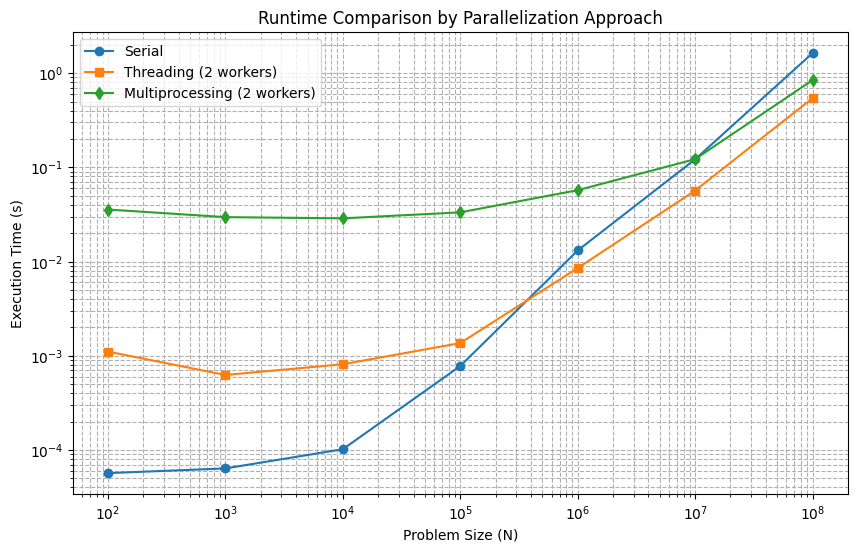

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool, shared_memory
import ctypes

def process_chunk(args):
    start, end, shm_name = args
    shm = shared_memory.SharedMemory(name=shm_name)
    data = np.ndarray((len(np.frombuffer(shm.buf, dtype=np.float64))), dtype=np.float64, buffer=shm.buf)
    return np.sum(1 / (1 + data[start:end]**2))

def process_chunk_thread(args):
    start, end, data = args
    return np.sum(1 / (1 + data[start:end]**2))

def serial_benchmark(data):
    start = time.time()
    result = np.sum(1 / (1 + data**2))
    return result, time.time() - start

def threading_benchmark(data, workers):
    chunk_size = len(data) // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size, data) for i in range(workers)]
    if len(data) % workers != 0:
        chunks[-1] = (chunks[-1][0], len(data), data)

    start = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        results = list(executor.map(process_chunk_thread, chunks))
    return sum(results), time.time() - start

def multiprocessing_benchmark(data, workers):
    shm = shared_memory.SharedMemory(create=True, size=data.nbytes)
    shm_data = np.ndarray(data.shape, dtype=data.dtype, buffer=shm.buf)
    shm_data[:] = data

    chunk_size = len(data) // workers
    chunks = [(i*chunk_size, (i+1)*chunk_size, shm.name) for i in range(workers)]
    if len(data) % workers != 0:
        chunks[-1] = (chunks[-1][0], len(data), shm.name)

    start = time.time()
    with Pool(workers) as pool:
        results = pool.map(process_chunk, chunks)
    end_time = time.time()

    shm.close()
    shm.unlink()  # Clean up shared memory

    return sum(results), end_time - start

def benchmark_suite():
    workers = 2  # For 2-core machine
    sizes = [10**2, 10**3, 10**4, 10**5, 10**6, 10**7, 10**8]
    serial_times = []
    thread_times = []
    process_times = []

    for size in sizes:
        data = np.linspace(0, 100, size).astype(np.float64)


        # Serial
        _, st = serial_benchmark(data)
        serial_times.append(st)

        # Threading
        _, tt = threading_benchmark(data, workers)
        thread_times.append(tt)

        # Multiprocessing
        _, pt = multiprocessing_benchmark(data, workers)
        process_times.append(pt)

    return sizes, serial_times, thread_times, process_times

def plot_results(sizes, serial, threads, processes):
    plt.figure(figsize=(10, 6))
    plt.loglog(sizes, serial, 'o-', label='Serial')
    plt.loglog(sizes, threads, 's-', label=f'Threading (2 workers)')
    plt.loglog(sizes, processes, 'd-', label=f'Multiprocessing (2 workers)')

    plt.xlabel('Problem Size (N)')
    plt.ylabel('Execution Time (s)')
    plt.title('Runtime Comparison by Parallelization Approach')
    plt.legend()
    plt.grid(True, which='both', linestyle='--')
    plt.show()

if __name__ == "__main__":
    sizes, serial, threads, processes = benchmark_suite()
    plot_results(sizes, serial, threads, processes)


## So, Multithreading is ALWAYS better than multiprocessing?

### 1. Handicapped multithreading in Python: GIL restriction: Why we get speedup with multithreading at all?

In [ ]:
import time
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import os
import threading
import numpy as np


# Define a CPU-bound function: compute the sum of squares up to n
def compute_sum_of_squares(n):
    total = 0
    pid = os.getpid()
    tid = threading.get_native_id()
    start = time.thread_time()
    #start = time.process_time()

    # non-vectorized (GIL)
    for i in range(1, n + 1):
        total += i ** 2
    '''
    # vectorized (GIL free)
    total = np.sum(np.random.rand(n))
    '''
    end = time.thread_time()
    #end = time.process_time()
    print(f"Problem size: {n}, CPU time for process: {pid}, thread: {tid} is: {end - start}\n")
    return total

# Get the number of CPU cores available
num_cores = multiprocessing.cpu_count()
print(f"Number of cores available: {num_cores}")

# Set the size of the computation
n = 1000000  # 10^8, a large enough value to make the task CPU-intensive

# 1. Sequential Execution
print("Sequential execution: \n")
start_time = time.perf_counter()
results_seq = [compute_sum_of_squares(n) for _ in range(1)]
seq_time = time.perf_counter() - start_time
#print(f"Sequential execution time: {seq_time:.2f} seconds")

# 2. Multi-threading Execution
print("Multithreaded execution: \n")
start_time = time.perf_counter()
with ThreadPoolExecutor(max_workers=num_cores) as executor:
    results_thread = list(executor.map(compute_sum_of_squares, [n // num_cores] * num_cores))
thread_time = time.perf_counter() - start_time
#print(f"Multi-threading execution time: {thread_time:.2f} seconds")

# 3. Multiprocessing Execution
print("Multiprocess execution: \n")
start_time = time.perf_counter()
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results_proc = list(executor.map(compute_sum_of_squares, [n // num_cores] * num_cores))
proc_time = time.perf_counter() - start_time
#print(f"Multiprocessing execution time: {proc_time:.2f} seconds")

Number of cores available: 2
Sequential execution: 

Problem size: 1000000, CPU time for process: 713, thread: 713 is: 0.08968214099999727

Multithreaded execution: 

Problem size: 500000, CPU time for process: 713, thread: 7273 is: 0.044252534

Problem size: 500000, CPU time for process: 713, thread: 7274 is: 0.044319418

Multiprocess execution: 

Problem size: 500000, CPU time for process: 7275, thread: 7275 is: 0.092740795

Problem size: 500000, CPU time for process: 7276, thread: 7276 is: 0.094791494



### Lets unleash TRUE multithreading
1. Why multiprocessing (finally) wins here over multithreading?

In [ ]:
%%writefile demo.cpp
#include <iostream>
#include <thread>
#include <vector>
#include <chrono>
#include <unistd.h>
#include <sys/wait.h>

// Function to increment a value a specified number of times
void increment(double& value, long long times) {
    for (long long i = 0; i < times; ++i) {
        value += 1.0;
    }
}

// Multi-threading version with false sharing
void run_multithreading(long long times) {
    // Array with 2 doubles, adjacent in memory (same cache line)
    std::vector<double> arr(2, 0.0);

    auto start = std::chrono::high_resolution_clock::now();

    // Create two threads, each incrementing its own element
    std::thread t1(increment, std::ref(arr[0]), times);
    std::thread t2(increment, std::ref(arr[1]), times);

    t1.join();
    t2.join();

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;
    std::cout << "Multi-threading time: " << duration.count() << " seconds" << std::endl;
}

// Multi-processing version with separate memory spaces
void run_multiprocessing(long long times) {
    auto start = std::chrono::high_resolution_clock::now();

    // Fork first child process
    pid_t pid1 = fork();
    if (pid1 == 0) { // Child 1
        double value = 0.0;
        increment(value, times);
        exit(0);
    }

    // Fork second child process
    pid_t pid2 = fork();
    if (pid2 == 0) { // Child 2
        double value = 0.0;
        increment(value, times);
        exit(0);
    }

    // Parent waits for both children to finish
    waitpid(pid1, NULL, 0);
    waitpid(pid2, NULL, 0);

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;
    std::cout << "Multi-processing time: " << duration.count() << " seconds" << std::endl;
}

int main() {
    const long long times = 1000000000; // 100 million iterations
    std::cout << "Running multi-threading version..." << std::endl;
    run_multithreading(times);
    std::cout << "Running multi-processing version..." << std::endl;
    run_multiprocessing(times);
    return 0;
}

Writing demo.cpp


In [ ]:
!g++ demo.cpp -o demo -std=c++11 -pthread

In [ ]:
!./demo

Running multi-threading version...
Multi-threading time: 4.65899 seconds
Running multi-processing version...
Multi-processing time: 4.63633 seconds


## So, How multithreading can go wrong?

### 1. GIL limitations

### IO-bound task

In [ ]:
import threading
import time
import urllib.request

def download(url):
    with urllib.request.urlopen(url) as response:
        return response.read()

urls = ["http://example.com"] * 10

# Serial implementation
start = time.time()
for url in urls:
    download(url)
print("Serial time:", time.time() - start)

# Multi-threaded implementation
threads = []
start = time.time()
for url in urls:
    thread = threading.Thread(target=download, args=(url,))
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
print("Multi-threaded time:", time.time() - start)

#### Compute-bound task

In [ ]:
import threading
import time

def compute_intensive(n):
    sum = 0
    for i in range(n):
        sum += i
    return sum

n = 10000000

# Serial implementation
start = time.time()
for _ in range(4):
    compute_intensive(n)
print("Serial time:", time.time() - start)

# Multi-threaded implementation
threads = []
start = time.time()
for _ in range(4):
    thread = threading.Thread(target=compute_intensive, args=(n,))
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
print("Multi-threaded time:", time.time() - start)

Serial time: 1.7647936344146729
Multi-threaded time: 2.6450061798095703


### Thread overhead

#### Long-running tasks

In [ ]:
import threading
import time

def long_task():
    time.sleep(1)  # Simulate a long-running task

# Serial implementation
start = time.time()
for _ in range(10):
    long_task()
print("Serial time:", time.time() - start)

# Multi-threaded implementation
threads = []
start = time.time()
for _ in range(10):
    thread = threading.Thread(target=long_task)
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
print("Multi-threaded time:", time.time() - start)

Serial time: 10.001480340957642
Multi-threaded time: 1.0016026496887207


#### Short tasks

In [ ]:
import threading
import time

def short_task():
    pass  # Very quick task

# Serial implementation
start = time.time()
for _ in range(10000):
    short_task()
print("Serial time:", time.time() - start)

# Multi-threaded implementation
threads = []
start = time.time()
for _ in range(10000):
    thread = threading.Thread(target=short_task)
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
print("Multi-threaded time:", time.time() - start)

Serial time: 0.0008447170257568359
Multi-threaded time: 1.0116851329803467


### Synchronization issues

#### Independent tasks

In [ ]:
import threading
import time

def independent_task():
    time.sleep(1)  # Simulate work

# Serial implementation
start = time.time()
for _ in range(10):
    independent_task()
serial_time = time.time() - start
print(f"Serial time: {serial_time:.2f} seconds")

# Multi-threaded implementation
threads = []
start = time.time()
for _ in range(10):
    thread = threading.Thread(target=independent_task)
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
threaded_time = time.time() - start
print(f"Multi-threaded time: {threaded_time:.2f} seconds")

Serial time: 10.00 seconds
Multi-threaded time: 1.00 seconds


#### Shared data, excessive locking

In [ ]:
import threading
import time

lock = threading.Lock()
shared_counter = 0

def increment_task():
    global shared_counter
    for _ in range(100000):
        with lock:
            shared_counter += 1

# Serial implementation
start = time.time()
for _ in range(4):
    increment_task()
print("Serial time:", time.time() - start)
print("Final counter:", shared_counter)

# Reset counter
shared_counter = 0

# Multi-threaded implementation with frequent locking
threads = []
start = time.time()
for _ in range(4):
    thread = threading.Thread(target=increment_task)
    threads.append(thread)
    thread.start()
for thread in threads:
    thread.join()
print("Multi-threaded time:", time.time() - start)
print("Final counter:", shared_counter)

Serial time: 0.11532831192016602
Final counter: 400000
Multi-threaded time: 0.11720466613769531
Final counter: 400000


## Can GPU-based-multithreading help in scaling that batched vectorized monte-carlo based neutron absorption over CPU-based mult-threading?
* 0.11 secs. for N = 10000000 vs around 5 secs. with CPU-multithreading (WOW!!)

In [ ]:

import torch
import time
import math

# Check for CUDA availability
assert torch.cuda.is_available(), "CUDA device not available!"
device = torch.device('cuda')

def simulate_gpu(N, max_steps=100, p_abs=0.01, batch_size=10_000_000):
    """GPU-accelerated simulation using PyTorch/CUDA"""
    absorbed = 0
    total_batches = math.ceil(N / batch_size)

    # Create CUDA stream for asynchronous operations
    stream = torch.cuda.Stream()

    for batch in range(total_batches):
        # Calculate current batch size
        start = batch * batch_size
        end = min((batch + 1) * batch_size, N)
        current_batch_size = end - start

        with torch.cuda.stream(stream):
            # Generate random numbers directly on GPU
            steps = torch.rand((current_batch_size, max_steps),
                              device=device,
                              dtype=torch.float32,
                              generator=torch.Generator(device=device))

            # Check for absorption (entirely on GPU)
            absorbed_mask = (steps < p_abs).any(dim=1)
            absorbed += absorbed_mask.sum().item()

        # Print progress every 10% of batches
        if (batch + 1) % max(1, total_batches // 10) == 0:
            print(f"Processed {end}/{N} neutrons ({((batch+1)/total_batches)*100:.1f}%)")

    # Synchronize stream before returning
    stream.synchronize()
    return absorbed

if __name__ == "__main__":
    # Configuration (can handle up to 1e12 neutrons easily)
    N = 10_000_000   # 10 billion neutrons
    MAX_STEPS = 100
    P_ABS = 0.01
    BATCH_SIZE = 50000 # ~3.8GB GPU memory per batch

    # Warm-up GPU
    _ = torch.rand(1000, 100, device=device)

    print(f"Simulating {N} neutrons with {MAX_STEPS} steps each")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}\n")

    # Run simulation
    start_time = time.time()
    absorbed = simulate_gpu(N, MAX_STEPS, P_ABS, BATCH_SIZE)
    total_time = time.time() - start_time

    print(f"\nTotal absorbed: {absorbed}")
    print(f"Total simulation time: {total_time:.2f} seconds")
    print(f"Neutrons per second: {N/total_time:.2e}")

Simulating 10000000 neutrons with 100 steps each
Using CUDA device: Tesla T4

Processed 1000000/10000000 neutrons (10.0%)
Processed 2000000/10000000 neutrons (20.0%)
Processed 3000000/10000000 neutrons (30.0%)
Processed 4000000/10000000 neutrons (40.0%)
Processed 5000000/10000000 neutrons (50.0%)
Processed 6000000/10000000 neutrons (60.0%)
Processed 7000000/10000000 neutrons (70.0%)
Processed 8000000/10000000 neutrons (80.0%)
Processed 9000000/10000000 neutrons (90.0%)
Processed 10000000/10000000 neutrons (100.0%)

Total absorbed: 6378600
Total simulation time: 0.11 seconds
Neutrons per second: 9.18e+07


## So, GPUs are silver bullets?

### 1. Small data-sizes

#### Large matrices

In [ ]:
import torch
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Large matrices
size = 10000
a = torch.rand(size, size, device=device)
b = torch.rand(size, size, device=device)

# CPU implementation
a_cpu = a.to("cpu")
b_cpu = b.to("cpu")
start = time.time()
torch.matmul(a_cpu, b_cpu)
cpu_time = time.time() - start
print(f"CPU time: {cpu_time:.2f} seconds")

# GPU implementation
start = time.time()
torch.matmul(a, b)
gpu_time = time.time() - start
print(f"GPU time: {gpu_time:.2f} seconds")

CPU time: 16.07 seconds
GPU time: 0.13 seconds


#### Small matrices

In [ ]:
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Small matrices
size = 10
a = torch.rand(size, size, device=device)
b = torch.rand(size, size, device=device)

# CPU implementation
a_cpu = a.to("cpu")
b_cpu = b.to("cpu")
start = time.time()
torch.matmul(a_cpu, b_cpu)
cpu_time = time.time() - start
print(f"CPU time: {cpu_time:.6f} seconds")

# GPU implementation
start = time.time()
torch.matmul(a, b)
gpu_time = time.time() - start
print(f"GPU time: {gpu_time:.6f} seconds")

CPU time: 0.003751 seconds
GPU time: 0.026187 seconds


### 2. Non-parallelizable tasks

#### Element-wise operations

In [ ]:
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Large tensor
size = 100_000_000
a = torch.rand(size, device=device)
b = torch.rand(size, device=device)

# CPU implementation
a_cpu = a.to("cpu")
b_cpu = b.to("cpu")
start = time.time()
result_cpu = a_cpu + b_cpu
cpu_time = time.time() - start
print(f"CPU time: {cpu_time:.2f} seconds")

# GPU implementation
start = time.time()
result_gpu = a + b
gpu_time = time.time() - start
print(f"GPU time: {gpu_time:.2f} seconds")

CPU time: 0.24 seconds
GPU time: 0.03 seconds


#### Cumulative sum

In [ ]:
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Large tensor
size = 100000000
a = torch.rand(size, device=device)

# CPU implementation
a_cpu = a.to("cpu")
start = time.time()
result_cpu = torch.cumsum(a_cpu, dim=0)
cpu_time = time.time() - start
print(f"CPU time: {cpu_time:.2f} seconds")

# GPU implementation
start = time.time()
result_gpu = torch.cumsum(a, dim=0)
gpu_time = time.time() - start
print(f"GPU time: {gpu_time:.2f} seconds")

CPU time: 0.47 seconds
GPU time: 0.00 seconds


### 3. Memory constraints

#### Large data but fits in GPU memory

In [ ]:
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Large tensor that fits in GPU memory
size = 10000
a = torch.rand(size, size, device=device)

# GPU implementation
start = time.time()
result_gpu = torch.matmul(a, a)
gpu_time = time.time() - start
print(f"GPU time: {gpu_time:.2f} seconds")

GPU time: 0.00 seconds


#### Too large data, OOM errors

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Attempt to allocate a very large tensor
try:
    size = 100000  # May exceed typical GPU memory
    a = torch.rand(size, size, device=device)
    print("Allocated on GPU")
except RuntimeError as e:
    print(f"GPU memory error: {e}")

# CPU implementation (will succeed if system has enough RAM)
try:
    a_cpu = torch.rand(size, size, device="cpu")
    print("Allocated on CPU")
except RuntimeError as e:
    print(f"CPU memory error: {e}")

GPU memory error: CUDA out of memory. Tried to allocate 37.25 GiB. GPU 0 has a total capacity of 14.74 GiB of which 13.48 GiB is free. Process 349280 has 1.26 GiB memory in use. Of the allocated memory 1.13 GiB is allocated by PyTorch, and 11.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


## How the multi-processing on GPU look like?

In [ ]:
import torch
import torch.multiprocessing as mp
import time

def worker(rank, data, result_queue):
    torch.cuda.set_device(rank % torch.cuda.device_count())
    data_gpu = data.to(f'cuda:{rank}')  # Move data to GPU
    partial_sum = data_gpu.sum()
    result_queue.put(partial_sum.item())

if __name__ == '__main__':
    # Check if the context is already set
    # and set it to 'spawn' only if it's not set yet
    try:
        mp.set_start_method('spawn', force=True) # This line attempts to force the start method.
    except RuntimeError:
        pass  # If the context is already set, ignore the error

    data = torch.randn(100_000_000)  # 100M elements on CPU
    result_queue = mp.Queue()
    num_processes = 4

    # Profile process creation and data serialization
    start_create = time.time()
    processes = []
    for i in range(num_processes):
        p = mp.Process(target=worker, args=(i, data, result_queue))
        processes.append(p)
    creation_time = time.time() - start_create
    print(f"Process creation time: {creation_time:.4f}s")

    # Start processes
    start_run = time.time()
    for p in processes:
        p.start()

    # Collect results
    results = []
    for _ in range(num_processes):
        results.append(result_queue.get())

    for p in processes:
        p.join()
    total = sum(results)
    run_time = time.time() - start_run
    print(f"Total sum: {total}, Execution time: {run_time:.4f}s")

Process creation time: 0.0001s


KeyboardInterrupt: 